In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Example 00: Two-link

Integrating two-link, using variational integrator based on Discrete Euler-Lagrange


# Problem definition


In [2]:
from varitop.integrator import DelIntegrator as DI
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.problem import VaritopProblem
from varitop.misc import euler_quadrature

import casadi as cs
import numpy as np

Matplotlib created a temporary cache directory at /tmp/matplotlib-hydll0yw because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
steps = 10000
t0 = 0
tf = 10
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_0 = np.array(
    [
        0,
        0,
        0,
        1,
        -1 * np.sin(np.pi / 3),
        1 * np.cos(np.pi / 3) + 1,
    ]
)

In [4]:
nodes = 50
problem = VaritopProblem()
problem.nodes = nodes

In [5]:
qs = problem.create_state("q", 6)
vs = problem.create_velocity("v", 6)

In [6]:
q, v = qs[0], vs[0]

In [7]:
kinetic_energy = cs.Function("kinetic", [q, v], [0.5 * v.T @ v])
potential_energy = cs.Function("potential", [q, v], [9.81 * (q[1] + q[3] + q[5])])
total_energy = cs.Function(
    "total", [q, v], [kinetic_energy(q, v) + potential_energy(q, v)]
)
lagrangian = cs.Function("L", [q, v], [kinetic_energy(q, v) - potential_energy(q, v)])
momentum = cs.Function("momentum", [q, v], [cs.jacobian(kinetic_energy(q, v), v)])

In [8]:
phi0 = cs.Function("phi0", [q], [q[0]])
phi1 = cs.Function("phi1", [q], [q[1]])
phi2 = cs.Function("phi2", [q], [(q[0] - q[2]) ** 2 + (q[1] - q[3]) ** 2 - 1])
phi3 = cs.Function("phi3", [q], [(q[2] - q[4]) ** 2 + (q[3] - q[5]) ** 2 - 1])

# Integration


In [9]:
di = DI()
di.lagrangian = lagrangian
di.rule = euler_quadrature
di.nq = 6

In [10]:
di.add_dynamics_constraint([phi0, phi1, phi2, phi3])

In [11]:
residual = di.step()
residual

Function(del:(q-1[6],q[6],q+1[6],lambda[4],dt)->(DEL Residual[10]) SXFunction)

In [12]:
q0 = cs.SX.sym("q0", 6)
q1 = cs.SX.sym("q1", 6)
q2 = cs.SX.sym("q2", 6)
lambdas = cs.SX.sym("lambdas", 4)
dt = cs.SX.sym("dt")

variable = cs.vertcat(q2, lambdas)

rfr = cs.Function("rfr", [variable, q0, q1, dt], [residual(q0, q1, q2, lambdas, dt)])

In [13]:
rf = cs.rootfinder("rf", "newton", rfr)

In [14]:
qs_sol = np.zeros((steps, 6))
qs_sol[0] = q_0
qs_sol[1] = q_0
ke = np.zeros(steps)
te = np.zeros(steps)
pe = np.zeros(steps)

ke[0:2] = kinetic_energy(q_0, np.zeros(6))
te[0:2] = total_energy(q_0, np.zeros(6))
pe[0:2] = potential_energy(q_0, np.zeros(6))

for i in tqdm(range(2, steps)):
    q0 = qs_sol[i - 2]
    q1 = qs_sol[i - 1]
    guess = np.hstack([q1, np.zeros(4)])
    qs_sol[i] = np.array(rf(guess, q0, q1, 0.001))[:6].ravel()
    dq = (qs_sol[i] - qs_sol[i - 1]) / 0.001
    ke[i] = kinetic_energy(qs_sol[i], dq)
    te[i] = total_energy(qs_sol[i], dq)
    pe[i] = potential_energy(qs_sol[i], dq)

 16%|█▌        | 1578/9998 [00:00<00:03, 2381.53it/s]

100%|██████████| 9998/9998 [00:04<00:00, 2411.15it/s]


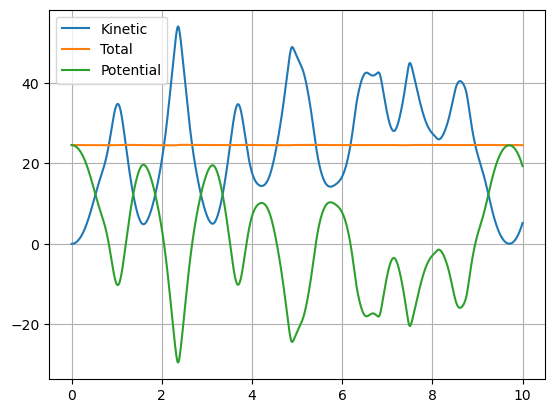

In [15]:
plt.plot(ts, ke, label="Kinetic")
plt.plot(ts, te, label="Total")
plt.plot(ts, pe, label="Potential")
plt.grid()
plt.legend()
plt.show()